# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#Do this to see 'workspace_utils' in the import list

%cd  /content/drive/MyDrive/aipnd-project-master/aipnd-project-master

root_dir = '/content/drive/MyDrive/aipnd-project-master/aipnd-project-master'

/content/drive/MyDrive/aipnd-project-master/aipnd-project-master


In [38]:
! pip install tensorflow matplotlib
! pip install tensorflow-datasets
! pip install tf-keras


## Import Resources

In [39]:
# TODO: Make all necessary imports.
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

from PIL import Image

import os


## Constant

In [40]:
batch_size = 32

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [41]:
# TODO: Load the dataset with TensorFlow Datasets.

# TODO: Create a training set, a validation set and a test set.

(training_set, validation_set, testing_set), info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:90%]', 'test'],
    with_info=True,
    as_supervised=True
)

## Explore the Dataset

In [42]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [43]:
print(info.description)

The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
occurring in the United Kingdom. Each class consists of between 40 and 258
images. The images have large scale, pose and light variations. In addition,
there are categories that have large variations within the category and several
very similar categories.

The dataset is divided into a training set, a validation set and a test set. The
training set and validation set each consist of 10 images per class (totalling
1020 images each). The test set consists of the remaining 6149 images (minimum
20 per class).

Note: The dataset by default comes with a test size larger than the train size.
For more info see this
[issue](https://github.com/tensorflow/datasets/issues/3022).


In [44]:
print(info.splits)

{'train': <SplitInfo num_examples=1020, num_shards=1>, 'test': <SplitInfo num_examples=6149, num_shards=2>, 'validation': <SplitInfo num_examples=1020, num_shards=1>}


In [45]:
print(info.features)

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
})


In [46]:
# TODO: Get the number of examples in each set from the dataset info.
print(f'The number of eamaples in training dataset is : {info.splits["train"].num_examples}')
print(f'The number of eamaples in test dataset is : {info.splits["test"].num_examples}')
print(f'The number of eamaples in validation dataset is : {info.splits["validation"].num_examples}')

print('*'*80)
# TODO: Get the number of classes in the dataset from the dataset info.
print(f'The number of classes is : {info.features["label"].num_classes}')

The number of eamaples in training dataset is : 1020
The number of eamaples in test dataset is : 6149
The number of eamaples in validation dataset is : 1020
********************************************************************************
The number of classes is : 102


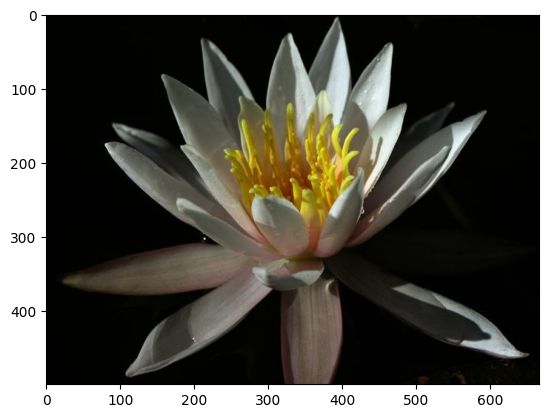

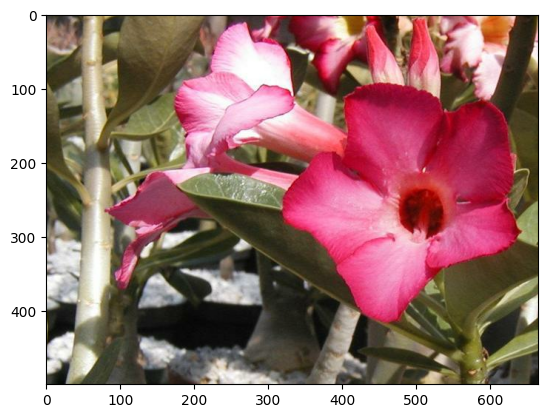

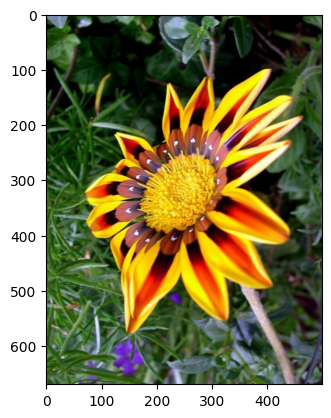

In [47]:
# TODO: Print the shape and corresponding label of 3 images in the training set.

for image, label in training_set.take(3):
  image = image.numpy()
  label = label.numpy()
  plt.imshow(image)
  plt.show()

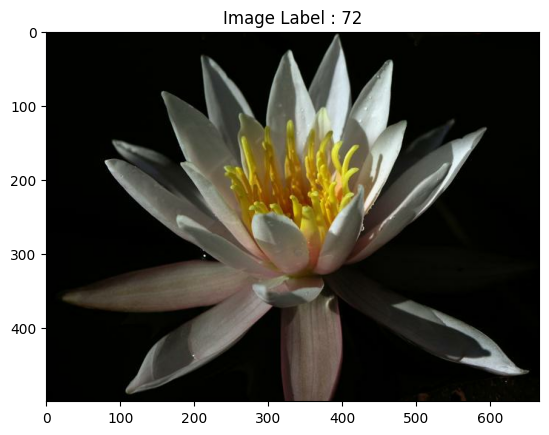

In [48]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.

for image, label in training_set.take(1):
  image = image.numpy()
  label = label.numpy()
  plt.title(f'Image Label : {label}')
  plt.imshow(image)
  plt.show()



## Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [49]:
with open(root_dir +'/label_map.json', 'r') as f:
    class_names = json.load(f)

In [50]:
class_names

{'0': 'pink primrose',
 '1': 'hard-leaved pocket orchid',
 '2': 'canterbury bells',
 '3': 'sweet pea',
 '4': 'english marigold',
 '5': 'tiger lily',
 '6': 'moon orchid',
 '7': 'bird of paradise',
 '8': 'monkshood',
 '9': 'globe thistle',
 '10': 'snapdragon',
 '11': "colt's foot",
 '12': 'king protea',
 '13': 'spear thistle',
 '14': 'yellow iris',
 '15': 'globe-flower',
 '16': 'purple coneflower',
 '17': 'peruvian lily',
 '18': 'balloon flower',
 '19': 'giant white arum lily',
 '20': 'fire lily',
 '21': 'pincushion flower',
 '22': 'fritillary',
 '23': 'red ginger',
 '24': 'grape hyacinth',
 '25': 'corn poppy',
 '26': 'prince of wales feathers',
 '27': 'stemless gentian',
 '28': 'artichoke',
 '29': 'sweet william',
 '30': 'carnation',
 '31': 'garden phlox',
 '32': 'love in the mist',
 '33': 'mexican aster',
 '34': 'alpine sea holly',
 '35': 'ruby-lipped cattleya',
 '36': 'cape flower',
 '37': 'great masterwort',
 '38': 'siam tulip',
 '39': 'lenten rose',
 '40': 'barbeton daisy',
 '41': '

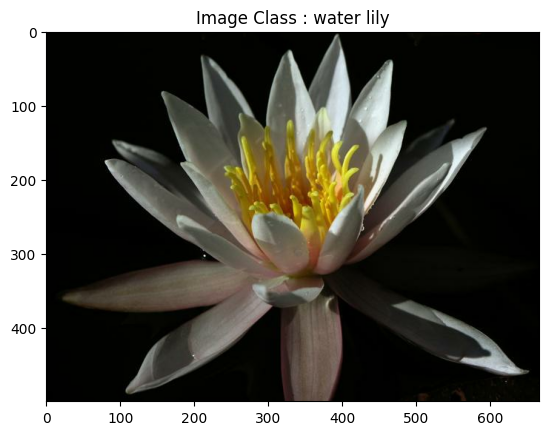

In [51]:
# TODO: Plot 1 image from the training set. Set the title
for image, label in training_set.take(1):
  image = image.numpy()
  label = label.numpy()
  plt.title(f'Image Class : {class_names[str(label)]}')
  plt.imshow(image)
  plt.show()


## Create Pipeline

In [52]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label


In [53]:
for images, labels in training_set.take(1):
    print(images.shape)

(500, 667, 3)


In [54]:
training_set = training_set.map(format_image)
validation_set = validation_set.map(format_image)
testing_set = testing_set.map(format_image)

In [55]:

training_set = training_set.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_set = testing_set.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students!

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model.

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [56]:
def build_model(input_shape, classes_number):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        alpha=1.0,
        include_top=False,
        weights="imagenet",
    )


    base_model.trainable = False


    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(classes_number, activation="softmax")
    ])


    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [57]:
input_shape = (224, 224, 3)
classes_number = 102

model = build_model(input_shape, classes_number)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
for images, labels in training_set.take(1):
    print(images.shape, labels.shape)


(32, 224, 224, 3) (32,)


In [59]:
for image, label in training_set.take(1):
    print("Image Shape:", image.shape)
    print("Label Shape:", label.shape)

Image Shape: (32, 224, 224, 3)
Label Shape: (32,)


In [60]:
history = model.fit(
    training_set,
    epochs=10,
    validation_data=validation_set
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 360ms/step - accuracy: 0.0351 - loss: 4.7889 - val_accuracy: 0.2059 - val_loss: 3.5498
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5587 - loss: 2.6032 - val_accuracy: 0.5882 - val_loss: 2.4466
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8464 - loss: 1.4509 - val_accuracy: 0.6569 - val_loss: 1.9177
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9552 - loss: 0.8864 - val_accuracy: 0.6863 - val_loss: 1.6265
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9733 - loss: 0.5636 - val_accuracy: 0.6961 - val_loss: 1.4731
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9953 - loss: 0.3869 - val_accuracy: 0.7353 - val_loss: 1.3660
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 0.2900 - val_accuracy: 0.7353 - val_loss: 1.2963
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 1.0000 - loss: 0.2270 - val_accuracy: 0.7353 -

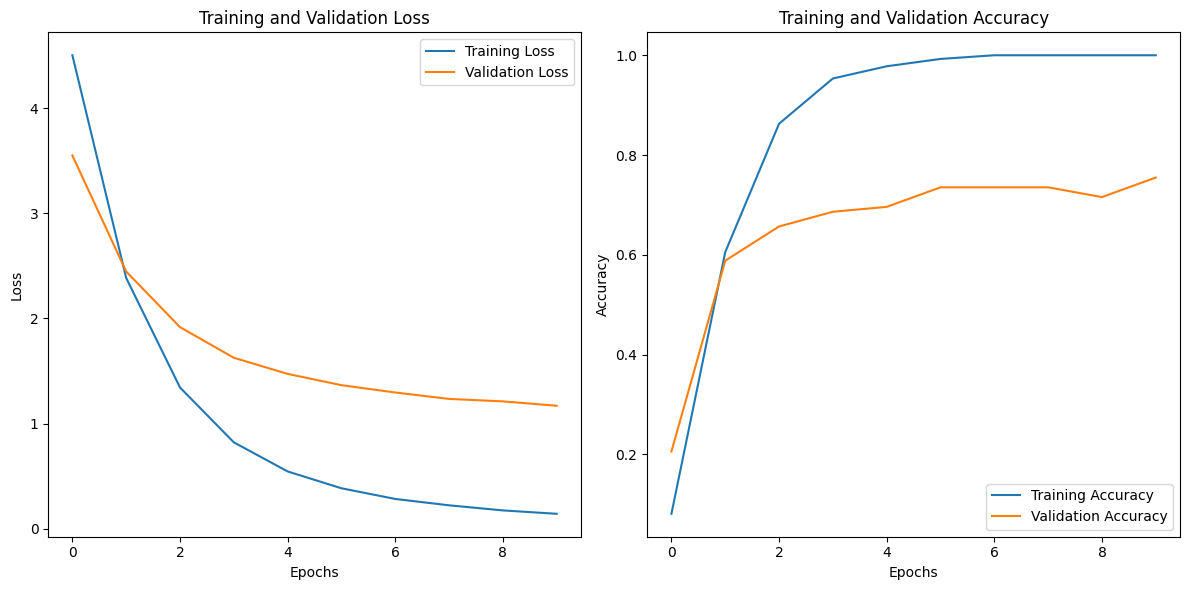

In [61]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.



# Extract loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [62]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

test_loss, test_acc = model.evaluate(testing_set)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7383 - loss: 1.1821
Test Loss: 1.1903
Test Accuracy: 0.7325


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [63]:
# TODO: Save your trained model as a Keras model.

model.save("flower_classifier_model_v1.h5")


## Load the Keras Model

Load the Keras model you saved above.

In [64]:
# TODO: Load the Keras model
loaded_model = load_model("flower_classifier_model_v1.h5")
loaded_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,648 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values.

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [65]:
# TODO: Create the process_image function
def process_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image.numpy(), axis=0)

    return image




To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size.

In [66]:
def prepare_image(image_path):
    image = Image.open(image_path)
    test_image = np.asarray(image)

    processed_image = process_image(test_image)
    processed_test_image = np.squeeze(processed_image)

    # Create a subplot to display the original and processed images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(test_image)
    ax1.set_title('Original Image')

    ax2.imshow(processed_test_image)
    ax2.set_title('Processed Image')

    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()

    return processed_image


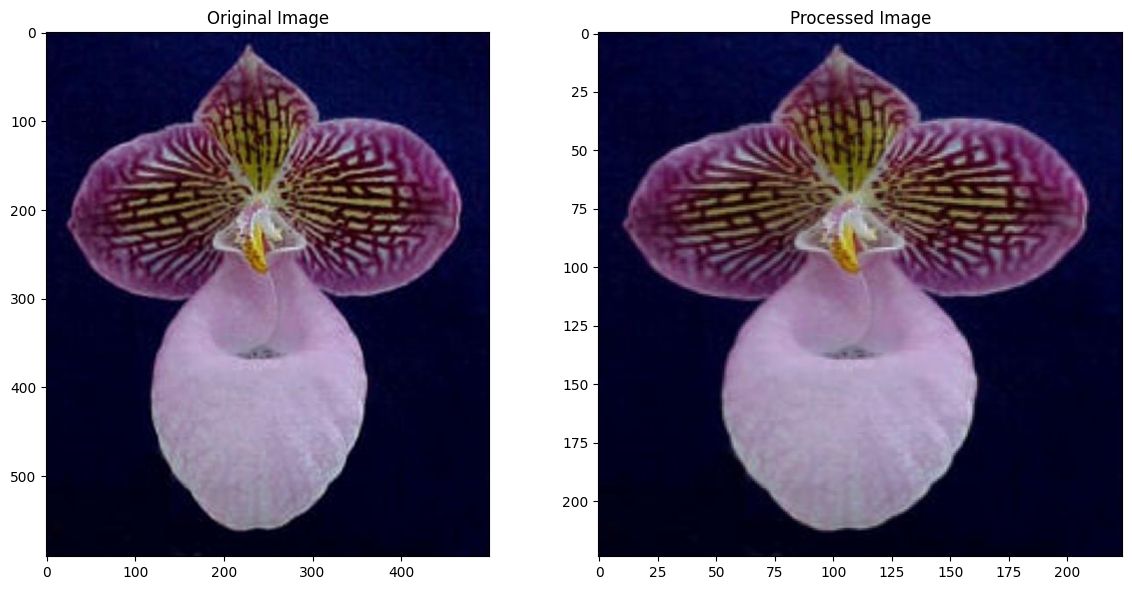

array([[[[0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         ...,
         [0.02390149, 0.01213679, 0.1964505 ],
         [0.00843841, 0.        , 0.18098743],
         [0.01719193, 0.00542722, 0.18974094]],

        [[0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         ...,
         [0.02187913, 0.01011443, 0.19442815],
         [0.01748074, 0.00571604, 0.19002976],
         [0.02290796, 0.01114326, 0.19545698]],

        [[0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         [0.        , 0.00392157, 0.18431373],
         ...,
         [0.01929273, 0.00752803, 0.19184175],
         [0.02412468, 0.01235998, 0.1966737 ],
         [0.02933304, 0.01756833, 0.20188205]],

        ...,

        [[0.        , 0.0035453 , 0.08197667],
         [0.        , 0.0035453 , 0.08197667]

In [67]:
image_path = root_dir+'/test_images/hard-leaved_pocket_orchid.jpg'
prepare_image(image_path)


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension.

In [79]:
def plot_top_k_classes(top_k_classes, top_k_probs):
    top_k_class_names = [class_names[str(idx)] for idx in top_k_classes]

    plt.figure(figsize=(8, 6))
    plt.barh( top_k_class_names, top_k_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Top K Flower Predictions')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
    plt.show()


In [80]:
def predict(image_path, model, top_k=5):

    processed_image = prepare_image(image_path)
    predictions = model.predict(processed_image)

    # Get the top K indices and probabilities
    top_k_indices = tf.argsort(predictions, axis=-1, direction='DESCENDING')[:, :top_k]
    top_k_probs = tf.gather(predictions, top_k_indices, batch_dims=1)

    # Convert to numpy arrays
    top_k_probs = top_k_probs.numpy().flatten()
    top_k_classes = top_k_indices.numpy().flatten().astype(str)

    plot_top_k_classes(top_k_classes, top_k_probs)

    for _class, prob in zip(top_k_classes, top_k_probs):
       print(f'class name: {class_names[str(_class)]} | Probability: {prob}')

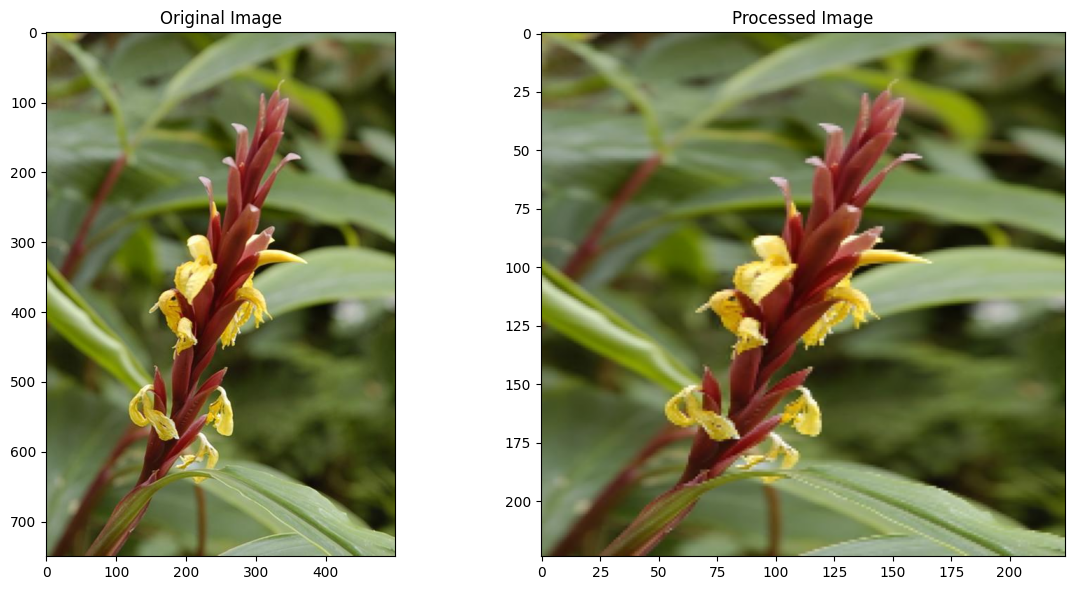

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


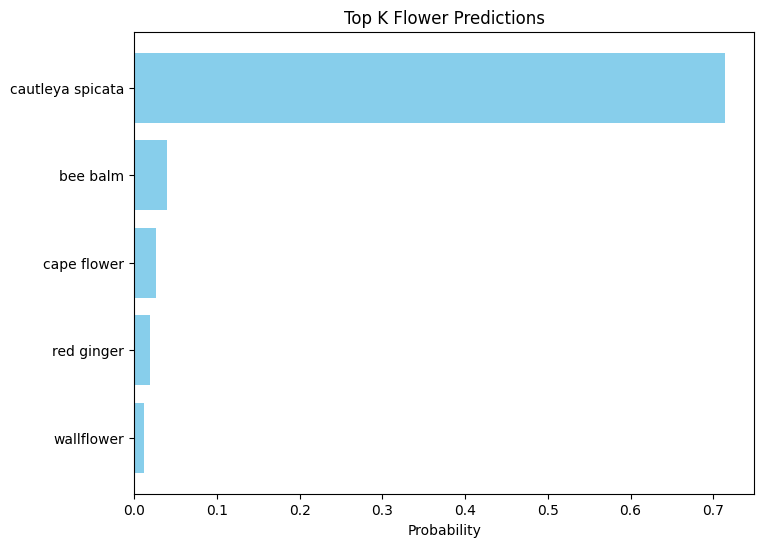

class name: cautleya spicata | Probability: 0.7135442495346069
class name: bee balm | Probability: 0.039389681071043015
class name: cape flower | Probability: 0.026876267045736313
class name: red ginger | Probability: 0.01981206052005291
class name: wallflower | Probability: 0.012421920895576477


In [81]:
predict(image_path, model, 5)


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`.

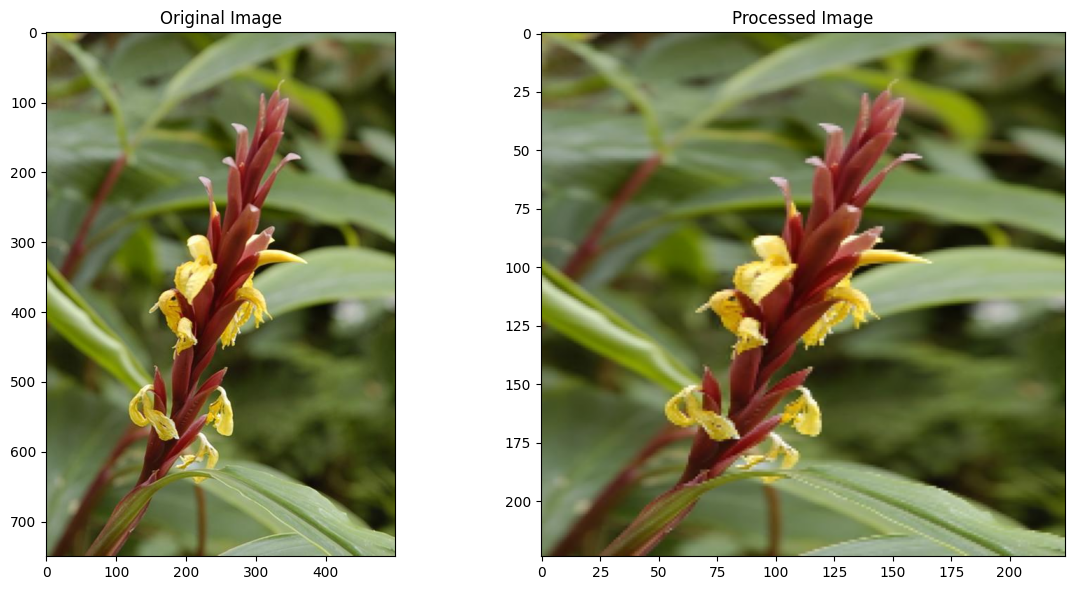

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


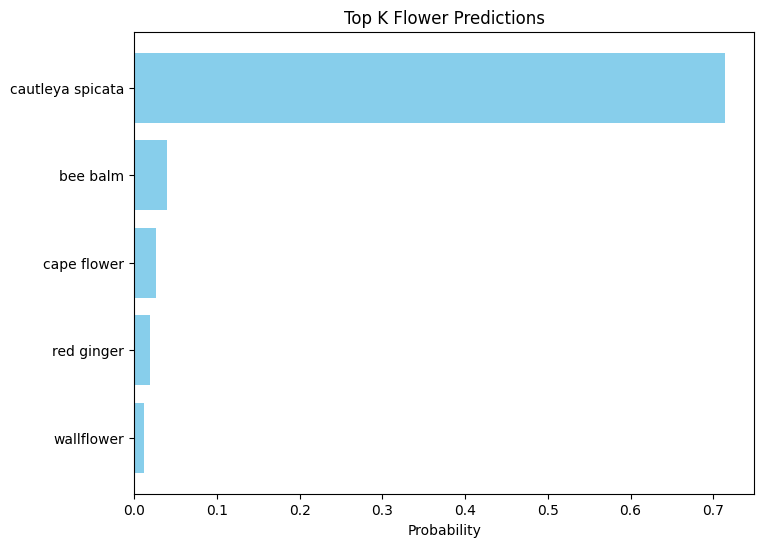

class name: cautleya spicata | Probability: 0.7135442495346069
class name: bee balm | Probability: 0.039389681071043015
class name: cape flower | Probability: 0.026876267045736313
class name: red ginger | Probability: 0.01981206052005291
class name: wallflower | Probability: 0.012421920895576477


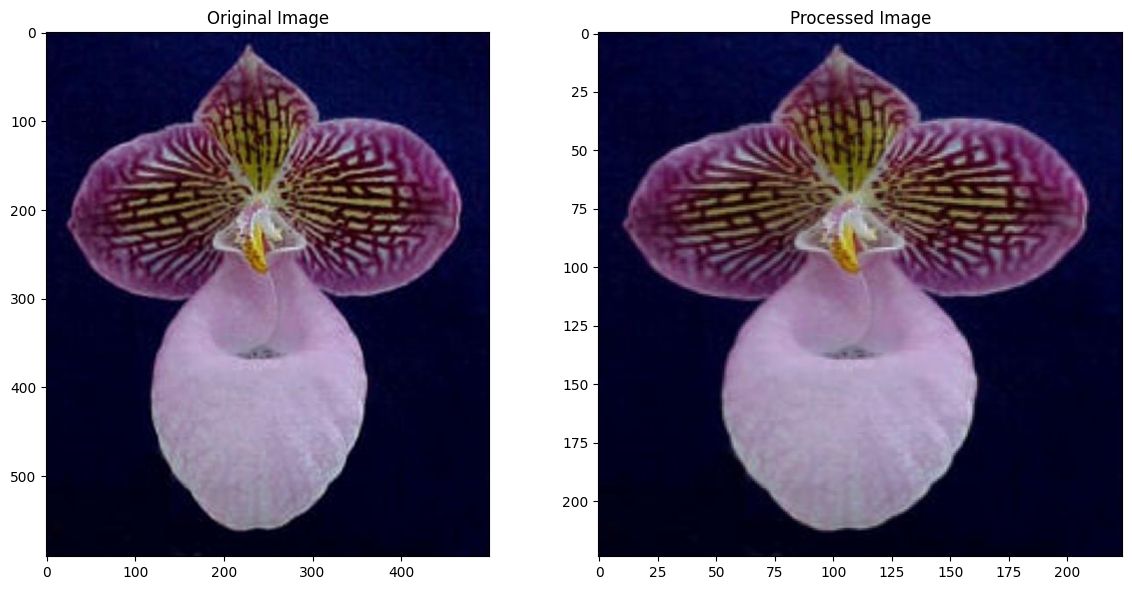

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


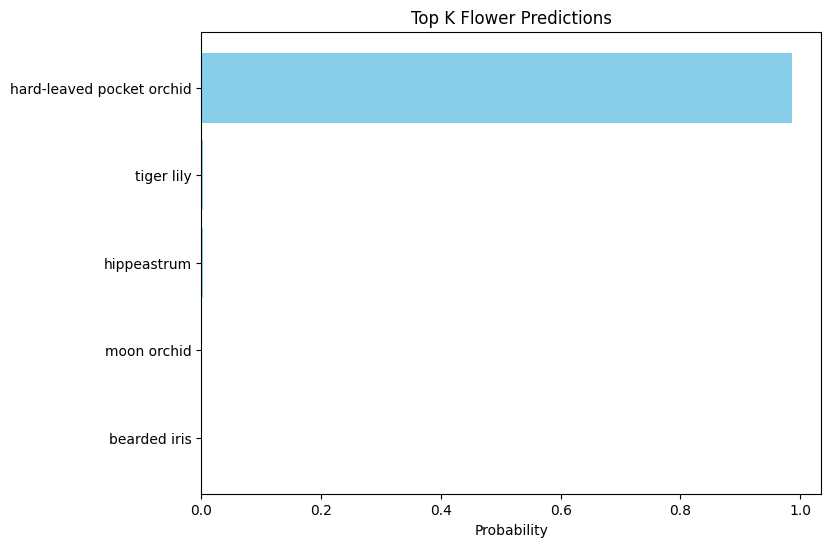

class name: hard-leaved pocket orchid | Probability: 0.9861286878585815
class name: tiger lily | Probability: 0.002130052074790001
class name: hippeastrum | Probability: 0.0018806760199368
class name: moon orchid | Probability: 0.0011380749056115746
class name: bearded iris | Probability: 0.0009091363754123449


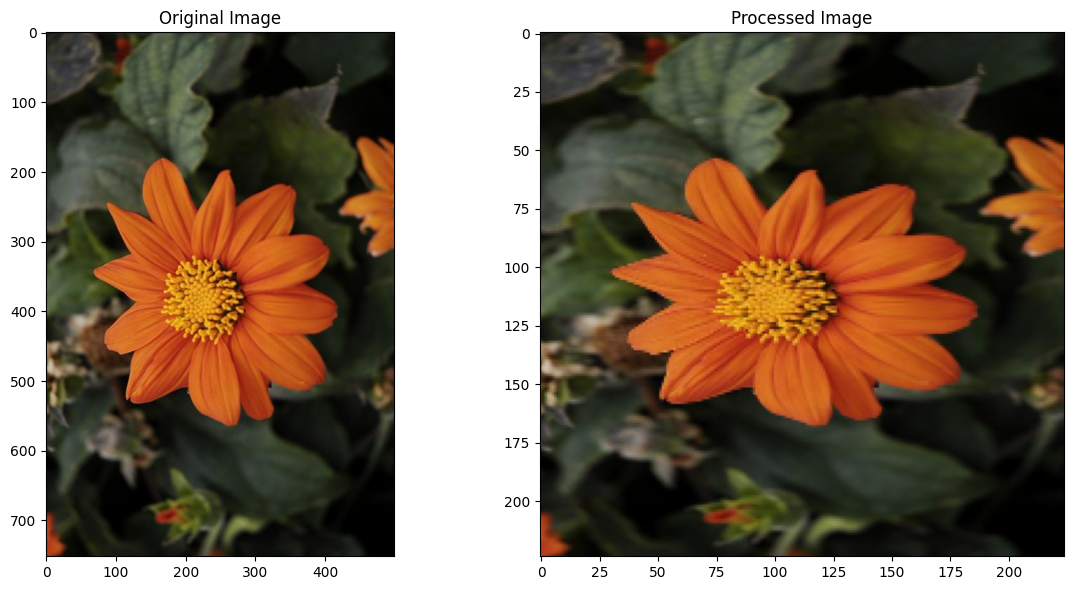

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


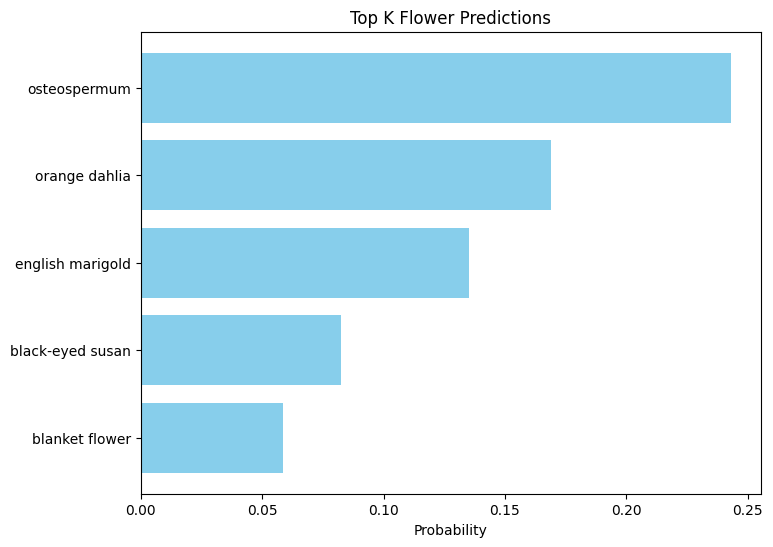

class name: osteospermum | Probability: 0.243073970079422
class name: orange dahlia | Probability: 0.1689888834953308
class name: english marigold | Probability: 0.13518795371055603
class name: black-eyed susan | Probability: 0.0825689360499382
class name: blanket flower | Probability: 0.05844883248209953


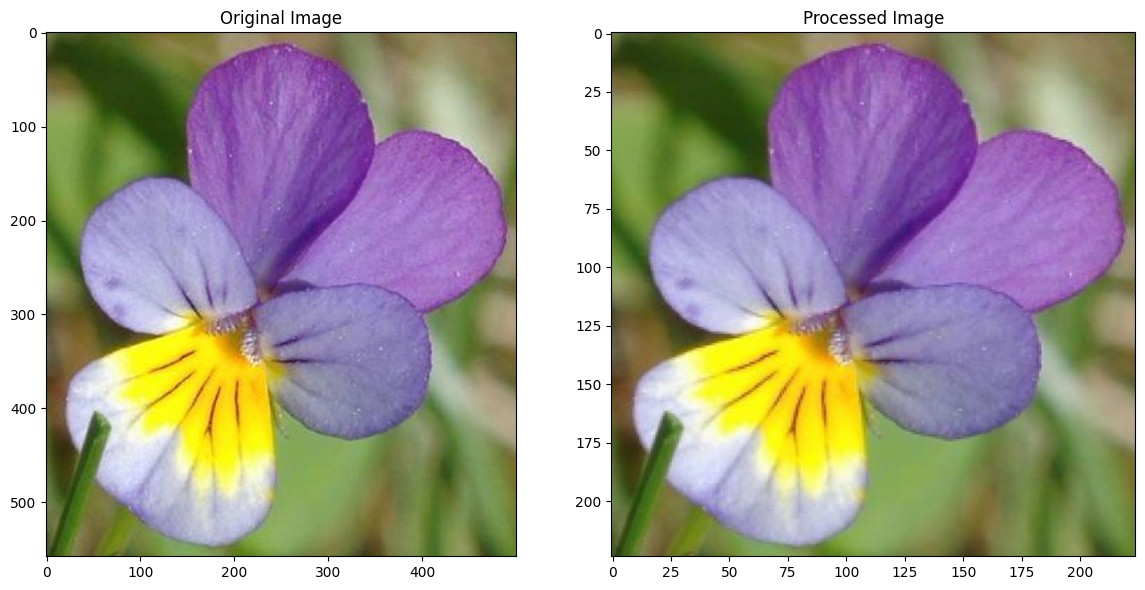

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


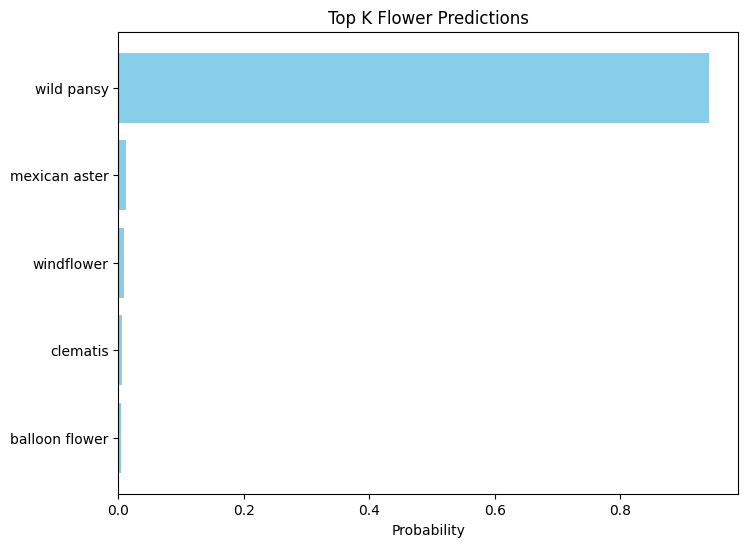

class name: wild pansy | Probability: 0.94139164686203
class name: mexican aster | Probability: 0.012092647142708302
class name: windflower | Probability: 0.008129311725497246
class name: clematis | Probability: 0.0053136833012104034
class name: balloon flower | Probability: 0.0039602005854249


In [82]:
# TODO: Plot the input image along with the top 5 classes

images_folder = root_dir+'/test_images'
images = [f for f in os.listdir(images_folder) if f.endswith(('jpg', 'png'))]

for image in images:
    image_path = images_folder+'/'+image
    predict(image_path, model, 5)

